# Maximum Likelihood Estimation
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), July 2017
The code in this Jupyter notebook was written using Python 3.6. It also uses data file `/data/Econ381totpts.txt` and the image file `/images/GBtree.png`. For the code to run properly, you should have the data file and the image file in the same folder as the Jupyter notebook file. Otherwise, you will have to change the respective lines of the code that read in the data and the image to reflect the location of that data.

## 1. General characterization of a model and data generating process
Each of the model estimation approaches that we will discuss in this section on Maximum Likelihood estimation (MLE) and in subsequent sections on generalized method of moments (GMM) and simulated method of moments (SMM) involves choosing values of the parameters of a model to make the model match some number of properties of the data. Define a model or a data generating process (DGP) as:

$$ F(x_t, z_t|\theta) = 0 $$

In reality, a model could also include inequalities representing constraints. But this is sufficient for our discussion. The goal of maximum likelihood estimation (MLE) is to choose the parameter vector of the model $\theta$ to maximize the likelihood of seeing the data produced by the model $(x_t, z_t)$.

An example of an economic model that follows the more general definition of $F(x_t, z_t|\theta) = 0$ is Brock and Mirman (1972). This model has multiple nonlinear dynamic equations, 7 parameters, 1 exogenous time series of variables, and about 5 endogenous time series of variables. A maximum likelihood model with

Another example of a model is a statistical distribution [e.g., the normal distribution $N(\mu, \sigma)$].

$$ Pr(x|\theta) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x - \mu)^2}{2\sigma^2}} $$

The probability of drawing value $x_i$ from the distribution $f(x|\theta)$ is $f(x_i|\theta)$. The probability of drawing the following vector of two observations $(x_1,x_2)$ from the distribution $f(x|\theta)$ is $f(x_1|\theta)\times f(x_2|\theta)$. We define the likelihood function of $N$ draws $(x_1,x_2,...x_N)$ from a model or distribution $f(x|\theta)$ as $\mathcal{L}$.

$$ \mathcal{L}(x_1,x_2,...x_N|\theta) \equiv \prod_{i=1}^N f(x_i|\theta) $$

Because it can be numerically difficult to maximize a product of percentages (one small value can make dominate the entire product), it is almost always easier to use the log likelihood function $\ln(\mathcal{L})$.

$$ \ln\Bigl(\mathcal{L}(x_1,x_2,...x_N|\theta)\Bigr) \equiv \sum_{i=1}^N \ln\Bigl(f(x_i|\theta)\Bigr) $$

The maximum likelihood estimate $\hat{\theta}_{MLE}$ is the following:

$$ \hat{\theta}_{MLE} = \theta:\quad \max_\theta \: \ln\mathcal{L} = \sum_{i=1}^N\ln\Bigl(f(x_i|\theta)\Bigr) $$

## 2. Comparisons of distributions and data

Import some data from the total points earned by all the students in two sections of my intermediate macroeconomics class for undergraduates at my previous University in a certain year (two semesters).

In [1]:
import numpy as np
import scipy.stats as sts

pts = np.loadtxt('data/Econ381totpts.txt')
pts.shape

(161,)

Let's create a histogram of the data.

<IPython.core.display.Javascript object>


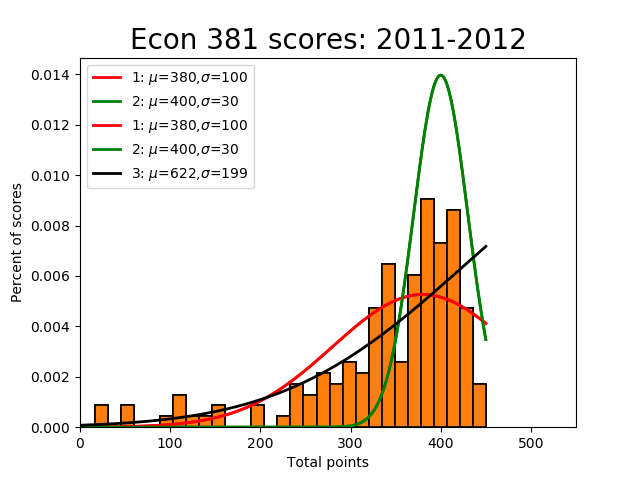

(0, 550)

In [20]:
import matplotlib.pyplot as plt
# This next command is specifically for Jupyter Notebook
%matplotlib notebook
count, bins, ignored = plt.hist(pts, 30, normed=True, edgecolor='black',
                                linewidth=1.2)
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel('Total points')
plt.ylabel('Percent of scores')
plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted

Now let's create a distribution around these data that we think fits it well.

In [21]:
# Define function that generates values of a potentially trucated normal
# probability density function (PDF)
def truncnorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the normal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

dist_pts = np.linspace(0, 450, 500)
mu_1 = 380
sig_1 = 100
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sig_1, 450),
         linewidth=2, color='r', label='1: $\mu$=380,$\sigma$=100')
plt.legend(loc='upper left')

mu_2 = 400
sig_2 = 30
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_2, sig_2, 450),
         linewidth=2, color='g', label='2: $\mu$=400,$\sigma$=30')
plt.legend(loc='upper left')


Which distribution will have the biggest log likelihood function? Why?

Let's compute the log likelihood function for this data for both of these distributions.

In [22]:
# Define log likelihood function for the normal distribution
def log_lik_trnorm(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given truncated
    normal distribution parameters mu and sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        truncnorm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, normal PDF values for mu and sigma
                  corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of normal PDF values
                  for mu and sigma corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = truncnorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood 1: ', log_lik_trnorm(pts, mu_1, sig_1, 450))
print('Log-likelihood 2: ', log_lik_trnorm(pts, mu_2, sig_2, 450))

Log-likelihood 1:  -919.460787599
Log-likelihood 2:  -1689.66776323


Why is the log likelihood value negative?

How do we estimate $\mu$ and $\sigma$ by maximum likelihood? What values of $\mu$ and $\sigma$ will maximize the likelihood function?
$$(\hat{\mu},\hat{\sigma})_{MLE} = (\mu, \sigma):\quad argmax_{\mu,\sigma}\:\mathcal{L}=\sum_{i=1}^N\ln\Bigl(f(x_i|\mu,\sigma)\Bigr)$$

## 3. How to set up a maximization (minimization) problem in Python
The Jupyter Notebook entitled [Root Finders and Minimizers in Python](https://github.com/OpenSourceMacro/BootCamp2017/blob/master/Tutorials/PythonRootMin.ipynb) provides a good tutorial for how to implement a minimizer in Python. A minimizer is a function that chooses a single value or a vector of values to minimize the result of a scalar-valued function of that vector. Any maximization problem can be restated as a minimization problem. Because minimization problems are more numerically stable and well defined, most numerical optimizers are stated as minimizers. The [scipy.optimize](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html) library has many types of root-finders and minimizers. For our maximum likelihood estimation problems, we will use the [scipy.optimize.minimize()](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function.

### 3.1. The criterion function
The first step is to write a function that takes two inputs and returns a scalar value.
1. The first input is either a scalar or a vector of values (the object `params` in the function `crit()` below). This object is the value or values being chosen to minimize the criterion function.
2. The second object is Python's variable length input objects `*args`, which is a tuple of variable length positional arguments. As you will see in the `minimize()` function, all the arguments must be passed into the criterion function in one tuple.
3. Lastly, you must make sure that the scalar criterion value that the function returns is the value of the problem stated as a minimization problem and not a maximization problem. In this case of maximum likelihood estimation, you want the negative of the log likelihood function.

In [23]:
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, cutoff)
    xvals  = (N,) vector, values of the normally distributed random
             variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_trnorm()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_trnorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

### 3.2. The minimize() function
The `minimize()` function is shorthand for `scipy.optimize.minimize()`. This function returns a dictionary of objects including the solution to the optimization problem and whether the problem actually solved. The `minimize` function has three mandatory arguments, plus a lot of options. You can experiment with the options on the [`minimize()` documentation page](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).
1. The first argument of the minimize function is the criterion function (`crit()` in this example) from which the `minimize()` function will test values of the parameters in searching for the minimum value.
2. The second argument is an initial guess for the values of the parameters that minimize the criterion function `crit()`.
3. The third argument is the tuple of all the objects needed to solve the criterion function in `crit()`.

In [33]:
import scipy.optimize as opt

mu_init = 400  # mu_2
sig_init = 70  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 450.0)
results = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 622.324159912  sig_MLE= 198.802487147


In [25]:
results

      fun: 910.5500686695552
 hess_inv: array([[ 222.5069619 ,  -16.37352792],
       [ -16.37352792,  110.26537961]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 180
      nit: 31
     njev: 45
   status: 0
  success: True
        x: array([ 622.32415991,  198.80248715])

In [26]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(pts, 30, normed=True, edgecolor='black',
                                linewidth=1.2)
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel('Total points')
plt.ylabel('Percent of scores')
plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

# Plot the two test distributions from before
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sig_1, 450),
         linewidth=2, color='r', label='1: $\mu$=380,$\sigma$=100')
plt.legend(loc='upper left')

plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_2, sig_2, 450),
         linewidth=2, color='g', label='2: $\mu$=400,$\sigma$=30')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_MLE, sig_MLE, 450),
         linewidth=2, color='k', label='3: $\mu$=622,$\sigma$=199')
plt.legend(loc='upper left')
plt.savefig('images/MLEplots.png')

In [27]:
print('Log-likelihood 1: ', log_lik_trnorm(pts, mu_1, sig_1, 450))
print('Log-likelihood 2: ', log_lik_trnorm(pts, mu_2, sig_2, 450))
print('MLE log-likelihood 3: ', log_lik_trnorm(pts, mu_MLE, sig_MLE, 450))

Log-likelihood 1:  -919.460787599
Log-likelihood 2:  -1689.66776323
MLE log-likelihood 3:  -910.55006867


Let's see if this likelihood function is well behaved by looking at a grid over possible values of $\mu$ and $\sigma$ for the given data.

<IPython.core.display.Javascript object>


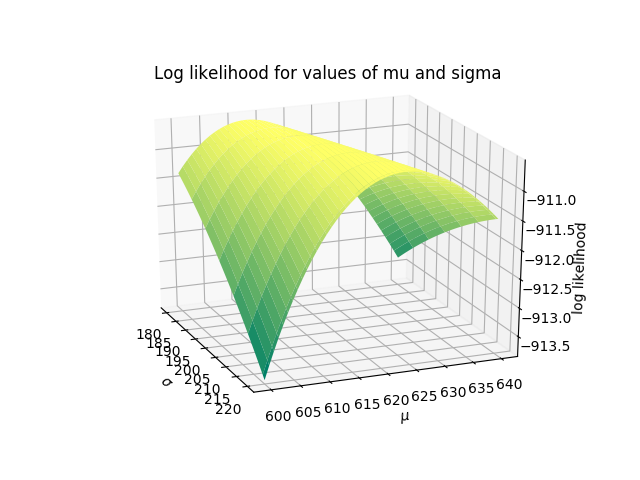

In [28]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

mu_vals = np.linspace(600, 640, 50)
sig_vals = np.linspace(180, 220, 50)
lnlik_vals = np.zeros((50, 50))
for mu_ind in range(50):
    for sig_ind in range(50):
        lnlik_vals[mu_ind, sig_ind] = log_lik_trnorm(pts, mu_vals[mu_ind],
                                                     sig_vals[sig_ind], 450)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, lnlik_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Log likelihood for values of mu and sigma')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'log likelihood')

### 3.3. Constrained minimization using the minimize() function
The `minimize()` function has many methods that can be used to find the parameter values that minimize some criterion function. These methods are called using the `method='MethodName'` optional input argument to the minimize function. Three of those methods allow for constrained minimization by providing upper and lower bounds for the parameters being chosen. These three methods are `'L-BFGS-B'`, `'TNC'`, and `'SLSQP'`.

Suppose you were trying to estimate $\mu$ and $\sigma$ of a truncated normal distribution as is the case above. The value of $\mu$ need not be constrained. However, the value of $\sigma$ must be strictly positive. You could include these bounds in a constrained minimization by using the following code.

In [29]:
results = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds=((None, None), (1e-10, None)))
print(results)
results.hess_inv.asmatrix()

      fun: 910.55006785201363
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,  -2.27373675e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 19
   status: 0
  success: True
        x: array([ 621.96174818,  198.6948965 ])


AttributeError: 'LbfgsInvHessProduct' object has no attribute 'asmatrix'

Note that you must set the lower bound of $\sigma$ equal to some small positive number close to zero. You cannot set it to zero itself because the bounds are inclusive. That is, the minimizer might try a value of $\sigma=0$ is the lower bound includes zero.

## 4. The variance-covariance matrix of ML estimates
Davidson and MacKinnon (2004, Sec. 10.4) have a great discussion four different estimators for the variance-covariance matrix of the maximum likelihood estimates. That is, we want to know what is the variance or uncertainty of our estimates for $\mu$ and $\sigma$, and how are those two estimates correlated. The four most common estimators for the VCV matrix of a maximum likelihood estimate are:
1. Empirical Hessian estimator (H)
2. Information matrix estimator (I)
3. Outer-product-of-the-gradient estimator (OPG)
4. Sandwich estimator (S)

All of these estimators of the VCV matrix intuitively measure how flat the likelihood function is at the estimated parameter values in the dimension of each estimated parameter. The Hessian is a matrix of second derivatives of the log likelihood function with respect to the parameters being chosen. The Hessian matrix therefore captures information about how the slope of the log likelihood function is changing in each direction.The empirical Hessian estimator is the most commonly used. One really nice property of Python's `minimize()` function is that one of the result objects is the inverse Hessian.

$$ \hat{VAR}_H(\hat{\theta}) =-H^{-1}(\hat{\theta}) $$

In [30]:
results
vcv_mle = results.hess_inv
stderr_mu_mle = np.sqrt(vcv_mle[0, 0])
stderr_sig_mle = np.sqrt(vcv_mle[1, 1])
corr_musig_mle = vcv_mle[0, 1] / (stderr_mu_mle * stderr_sig_mle)
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)
print('Correlation coefficient', corr_musig_mle)

TypeError: 'LbfgsInvHessProduct' object is not subscriptable

## 5. Hypothesis testing
Can we reject the hypothesis that $\mu=400$ and $\sigma=70$ with 95% confidence? How do you answer that question? What does the figure tell us about this answer? In this section, we will discuss four ways to perform hypothesis testing.
1. Two standard errors (back of the envelope, approximation)
2. Likelihood ratio test
3. Wald test
4. Lagrange multiplier test

Davidson and MacKinnon (2004, Sec. 10.5) have a more detailed discussion of methods 2, 3, and 4.

### 5.1. Back of the envelope, two standard errors (assuming normality)
A really quick approach to hypothesis testing is to see if your hypothesized values are within two standard errors of the estimated values. This approach is not completely correct because estimates in the log likelihood function are not symmetrically distributed. But it is at least a first approximation. 

In [31]:
lb_mu_95pctci = mu_MLE - 2 * stderr_mu_mle
print('mu_2=', mu_2, ', lower bound 95% conf. int.=', lb_mu_95pctci)

lb_sig_95pctci = sig_MLE - 2 * stderr_sig_mle
print('sig_2=', sig_2, ', lower bound 95% conf. int.=', lb_sig_95pctci)

NameError: name 'stderr_mu_mle' is not defined

### 5.2. Likelihood ratio test
The likelihood ratio test is the simplest and, therefore, the most common of the three more precise methods (2, 3, and 4). Let your maximum likelihood estimation have $p$ parameters (the vector $\theta$ has $p$ elements), let $\hat{\theta}_{MLE}$ be the maximum likelihood estimate, and let $\tilde{\theta}$ be your hypothesized values of the parameters. The likelihood ratio test statistic is the following.

$$ LR(\tilde{\theta}|\hat{\theta}_{MLE}) = 2\Bigl(\ln\ell(\hat{\theta}_{MLE}) - \ln\ell(\tilde{\theta})\Bigr) \sim \chi^2(p) $$

Note that this is a joint test of the likelihood of $H_0: \mu_0, \sigma_0$. The value of the $\chi^2(p)$ has the following interpretation. The area under the $\chi^2(p)$ pdf from $LR$ and above is the significance level or $p$-value. It represents the probability that the null hypothesis $\tilde{\theta}$ is true given the MLE estimate $\hat{\theta}_{MLE}$. More precisely, it represents the probability of null hypotheses with LR test statistics greater than or equal to (worse) the LR statistic from the null hypothese $\tilde{\theta}$. When this $p$-value is small, it it highly unlikely that the null hypothesis is true. You can calculate the $\chi^2(p)$ significance level by taking one minus the cdf of $\chi^2(p)$ at the $LR$ value.

In [32]:
log_lik_h0 = log_lik_trnorm(pts, mu_1, sig_1, 450)
log_lik_mle = log_lik_trnorm(pts, mu_MLE, sig_MLE, 450)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.000134934790577


## 6. Linear regression with MLE
Although linear regression is most often performed using the ordinary least squares (OLS) estimator, which is a particular type of generalized method of moments (GMM) estimator, this can also be done using MLE. A simple regression specification in which the dependent variable $y_i$ is a linear function of two independent variables $x_{1,i}$ and $x_{2,i}$ is the following:

$$ y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \varepsilon_i \quad\text{where}\quad \varepsilon_i\sim N\left(0,\sigma^2\right) $$

If we solve this regression equation for the error term $\varepsilon_i$, we can start to see how we might estimate the parameters of the model by maximum likelihood.

$$ \varepsilon_i = y_i - \beta_0 - \beta_1 x_{1,i} - \beta_2 x_{2,i} \sim N\left(0,\sigma^2\right) $$

The parameters of the regression model are $(\beta_0, \beta_1, \beta_2, \sigma)$. Given some data $(y_i, x_{1,i}, x_{2,i})$ and given some parameter values $(\beta_0, \beta_1, \beta_2, \sigma)$, we could plot a histogram of the distribution of those error terms. And we could compare that empirical histogram to the assumed histogram of the distribution of the errors $N(0,\sigma^2)$. ML estimation of this regression equation is to choose the paramters $(\beta_0, \beta_1, \beta_2, \sigma)$ to make that empirical distribution of errors $\varepsilon_i$ most closely match the assumed distribution of errors $N(0,\sigma^2)$.

## 7. Generalized beta family of distributions
For exercises in this section, you will need to know the functional forms of four continuous univariate probability density functions (PDF's), each of which are part of the generalized beta family of distributions. The figure below is the generalized beta family of distributions [taken from McDonald and Xu (1995, Fig. 2)].

![title](images/GBtree.png)

The lognormal distribution (LN) is the distribution of the exponential of a normally distributed variable with mean $\mu$ and standard deviation $\sigma$. If the variable $x_i$ is lognormally distributed $x_i\sim LN(\mu,\sigma)$, then the log of $x_i$ is normally distributed $\ln(x_i)\sim N(\mu,\sigma)$. The PDF of the lognormal distribution is the following.

$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$

Note that the lognormal distribution has a support that is strictly positive. This is one reason why it is commonly used to approximate income distributions. A household's total income is rarely negative. The lognormal distribution also has a lot of the nice properties of the normal distribution.

Another two-parameter distribution with strictly positive support is the gamma (GA) distribution. The pdf of the gamma distribution is the following.

$$ \text{(GA):}\quad f(x;\alpha,\beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

The gamma function $\Gamma(\cdot)$ within the gamma (GA) distribution is a common function that has a preprogrammed function in most programming languages.

The lognormal (LN) and gamma (GA) distributions are both two-parameter distributions and are both special cases of the three-parameter generalized gamma (GG) distribution. The pdf of the generalized gamma distribution is the following.

$$ \text{(GG):}\quad f(x;\alpha,\beta,m) = \frac{m}{\beta^\alpha \Gamma\left(\frac{\alpha}{m}\right)}x^{\alpha-1}e^{-\left(\frac{x}{\beta}\right)^m},\quad x\in[0,\infty), \:\alpha,\beta,m>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

The relationship between the generalized gamma (GG) distribution and the gamma (GA) distribution is straightforward. The GA distribution equals the GG distribution at $m=1$.

$$ GA(\alpha,\beta) = GG(\alpha,\beta,m=1) $$

The relationship between the generalized gamma (GG) distribution and the lognormal (LN) distribution is less straightforward. The LN distribution equals the GG distribution as $\alpha$ goes to zero, $\beta = (\alpha\sigma)^{\frac{2}{\alpha}}$, and $m = \frac{\alpha\mu+1}{\alpha^2\sigma^2}$. See McDonald, et al (2013) for derivation.

$$ LN(\mu,\sigma) = \lim_{\alpha\rightarrow 0}GG\left(\alpha,\beta=(\alpha\sigma)^{\frac{2}{\alpha}},m=\frac{\alpha\mu+1}{\alpha^2\sigma^2}\right) $$

The last distribution we describe is the generalized beta 2 (GB2) distribution. Like the GG, GA, and LN distributions, it also has a strictly positive support. The PDF of the generalized beta 2 distribution is the following.

$$ \text{(GB2):}\quad f(x;a,b,p,q) = \frac{a x^{ap-1}}{b^{ap}B(p,q)\left(1 + \left(\frac{x}{b}\right)^a\right)^{p+q}},\quad x\in[0,\infty), \:a,b,p,q>0 $$
$$ \quad\text{where}\quad B(v,w)\equiv\int_0^1 t^{v-1}(1-t)^{w-1}dt $$

The beta function $B(\cdot,\cdot)$ within the GB2 distribution is a common function that has a preprogrammed function in most programming languages. The three-parameter generalized gamma (GG) distribution is a nested case of the four-parameter generalized beta 2 (GB2) distribution as $q$ goes to $\infty$ and for $a=m$, $b=q^{1/m}\beta$, and $p=\frac{\alpha}{m}$. See McDonald (1984, p. 662) for a derivation.

$$ GG(\alpha,\beta,m) = \lim_{q\rightarrow\infty}GB2\left(a=m,b=q^{1/m}\beta,p=\frac{\alpha}{m},q\right) $$

The statistical family tree figure above shows the all the relationships between the various PDF's in the generalized beta family of distributions.

## 8. References
* Brock, William A. and Leonard J. Mirman, "Optimal Economic Growth and Uncertainty: The Discounted Case," *Journal of Economic Theory*, 4:3, pp. 479-513 (June 1972).
* Davidson, Russell and James G. MacKinnon, *Econometric Theory and Methods*, Oxford University Press (2004).
* McDonald, James B., "Some Generalized Functions for the Size Distribution of Income," *Econometrica* 52:3, pp. 647-665 (May 1984).
* McDonald, James B. and Yexiao Xu, "A Generalization of the Beta Distribution with Applications," *Journal of Econometrics*, 66:1-2, pp. 133-152 (March-April 1995).
* McDonald, James B., Jeff Sorensen, and Patrick A. Turley, "Skewness and Kurtosis Properties of Income Distribution Models," *Review of Income and Wealth*, 59:2, pp. 360-374 (June 2013).